In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [2]:
import tensorflow as tf
from tensorflow import keras

%load_ext tensorboard

2024-04-29 14:02:08.692952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:02:10.855632: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 14:02:14.462999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dchen/anaconda3/bin:/home/dchen/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/dchen/Documents/homer/bin:/home/dchen/Documents/10

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
cdr3_to_X = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
ag_to_X = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)

# read in validation data
hit_val = pd.read_csv('../outputs/model_v5/validation.pos.csv', index_col=0)
irr_val = pd.read_csv('../outputs/model_v5/validation.neg.csv', index_col=0)

# create X for validation
X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
# combine
X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
X_val = X_val_cdr3s.join(X_val_epitopes)

# grab y for validation
y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])),
                     pd.Series(np.zeros(irr_val.shape[0]))], axis=0).astype(int)
y_val = y_val.reset_index().iloc[:, 1:][0]

# confirm the same length
assert X_val.shape[0] == y_val.shape[0]

# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X_val = X_val[means.index]
# normalize
X_val -= means
X_val /= stds

In [16]:
# load in the model
model = keras.models.load_model('../outputs/model_v5/model_v5.r1.keras')

# testing predictions
y_pred = model.predict([X_val.loc[:, X_val.columns.str.startswith('cdr3:')],
                        X_val.loc[:, X_val.columns.str.startswith('ag:')]],
                       workers=40, use_multiprocessing=True)[:, 0]

# derive the package for all
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_val, y_pred)
auc_value = auc(fpr, tpr)
stats_all = [fpr, tpr, auc_value]
auc_value

3970/3970 [==============================] - 8s 2ms/step


0.8887224670294278

In [17]:
# testing predictions
y_pred = model.predict([X_val.loc[:, X_val.columns.str.startswith('cdr3:')],
                        np.zeros((X_val.shape[0], sum(X_val.columns.str.startswith('ag:'))))],
                       workers=40, use_multiprocessing=True)[:, 0]

# derive the package for tcr
fpr, tpr, _ = roc_curve(y_val, y_pred)
auc_value = auc(fpr, tpr)
stats_tcronly = [fpr, tpr, auc_value]
auc_value

3970/3970 [==============================] - 8s 2ms/step


0.7331931484567071

In [18]:
# testing predictions
y_pred = model.predict([np.zeros((X_val.shape[0], sum(X_val.columns.str.startswith('cdr3:')))),
                        X_val.loc[:, X_val.columns.str.startswith('ag:')]],
                       workers=40, use_multiprocessing=True)[:, 0]

# derive the package for tcr
fpr, tpr, _ = roc_curve(y_val, y_pred)
auc_value = auc(fpr, tpr)
stats_agonly = [fpr, tpr, auc_value]
auc_value

3970/3970 [==============================] - 8s 2ms/step


0.5000944857083701

[Text(0.5, 0, 'False Positive Rate'), Text(0, 0.5, 'True Positive Rate')]

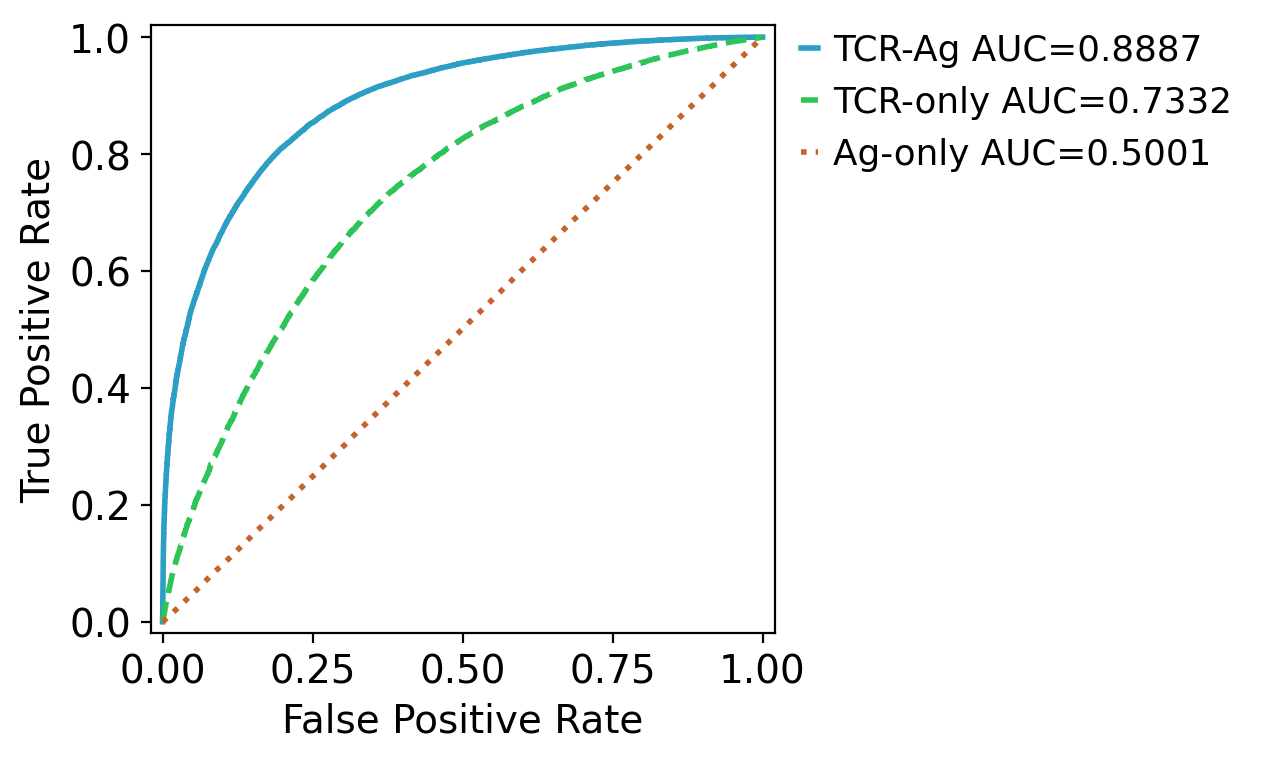

In [26]:
# create roc auc curve
fig, ax = plt.subplots(figsize=[4, 4])
ax.grid(False)
# plot the all
ax.plot(stats_all[0], stats_all[1], color='#2D9FC4', linestyle='-',
        linewidth=2, label=r'TCR-Ag AUC=%0.4f' % (stats_all[2]))
# plot the tcr only
ax.plot(stats_tcronly[0], stats_tcronly[1], color='#2dc458', linestyle='--',
        linewidth=2, label=r'TCR-only AUC=%0.4f' % (stats_tcronly[2]))
# plot the ag only
ax.plot(stats_agonly[0], stats_agonly[1], color='#c4642d', linestyle='dotted',
        linewidth=2, label=r'Ag-only AUC=%0.4f' % (stats_agonly[2]))
# add on labels and adjust limits
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.legend(bbox_to_anchor=(.99,1.04), bbox_transform=ax.transAxes,
          frameon=False, loc='upper left')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')